# BEE 4750 Homework 5: Mixed Integer and Stochastic Programming

**Name**: Sarah Cooke. Laura Akey, Fabien DeSilva

**ID**: sec275, lka27, fmd48

> **Due Date**
>
> Thursday, 12/05/24, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will use mixed integer programming to solve a
    waste load allocation problem.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [5]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/CEE 4750/hw5-fls-1`


In [6]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

## Problems (Total: 30 Points)

### Problem 1 (30 points)

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided below.

-   **LF**: Capacity 200 Mg, fixed cost \$2000/day, tipping cost
    \$50/Mg;
-   **MRF**: Capacity 350 Mg, fixed cost \$1500/day, tipping cost
    \$7/Mg, recycling cost \$40/Mg recycled;
-   **WTE**: Capacity 210 Mg, fixed cost \$2500/day, tipping cost
    \$60/Mg;

The MRF recycling rate is 40%, and the ash fraction of non-recycled
waste is 16% and of recycled waste is 14%. Transportation costs are
\$1.5/Mg-km, and the relative distances between the cities and
facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

**In this problem**:

-   Formulate the waste load allocation problem and implement it in
    `JuMP`.
-   Draw a diagram showing the flows of waste between the cities and the
    facilities. Which facilities (if any) will not be used? Does this
    solution make sense?

$Problem$ $Solution$

**Optimization Equation:**\
minimize (transportation costs + disposal costs)

transportation costs = cost of transporting waste from source to disposal x distance from source to disposal x amount of waste transported

disposal costs = fixed costs of operations + variable cost of disposing waste

**Variable Description:**\
w_1_lf - waste from city 1 to landfill (LF)\
w_2_lf - waste from city 2 to landfill (LF)\
w_3_lf - waste from city 3 to landfill (LF)\
w_1_mrf - waste from city 1 materials recycling facility (MRF)\
w_2_mrf - waste from city 2 materials recycling facility (MRF)\
w_3_mrf - waste from city 3 materials recycling facility (MRF)\
w_1_wte - waste from city 1 to waste to energy facility (WTE)\
w_2_wte - waste from city 2 to waste to energy facility (WTE)\
w_3_wte - waste from city 3 to waste to energy facility (WTE)\
r_mrf_lf - residuals waste from mrf to landfill\
r_mrf_wte - residuals waste from mrf to wte\
r_wte_lf - residuals waste from wte to landfill\
y_lf - operating status of the landfill\
y_mrf - operating status of the mrf\
y_wte - operating status of the wte


**Constraint Equations:**\
The residual waste from the mrf is 0.6 times the total waste from the cities that the mrf recieves, since there is a 40% recycle rate. This waste goes to both the landfill and the waste to energy plant.\
r_mrf_lf + r_mrf_wte = 0.6(w_1_mrf + w_2_mrf + w_3_mrf)

The residual waste from the wte is equal to 14% of the waste it recieves from the recylcing plant plus 16% of the waste it recieves from the cities. This waste goes to the landfill.\
r_wte_lf = 0.14(r_mrf_wte) + 0.16(w_1_wte + w_2_wte + w_3_wte)

The landfill is either turned on or off depending if it is used or not. If anything is sent there then it is on and costs money to operate. This variable will always be on as long as any waste from any city is produced.\
y_lf = {1}

The mrf is either turned on or off depending if it is used or not. If anything is sent there then it is on and costs money to operate.\
y_mrf = {0, 1}

The wte is either turned on or off depending if it is used or not. If anything is sent there then it is on and costs money to operate.\
y_wte = {0, 1}

City 1 produces 100 Mg/day of waste.\
w_1_lf + w_1_mrf + w_1_wte = 100

City 2 produces 90 Mg/day of waste.\
w_2_lf + w_2_mrf + w_2_wte = 90

City 3 produces 120 Mg/day of waste.\
w_1_lf + w_1_mrf + w_1_wte = 120


In [7]:
# Define the model
model = Model(HiGHS.Optimizer)

# Parameters where the order is [LF,MRF,WTE]
city_waste = [100, 90, 120] # Mg/day
facility_capacities = [200, 350, 210] # Mg
fixed_costs = [2000, 1500, 2500] #$/Day
tipping_costs = [50, 7, 60] # $/Mg
recycling_cost = 40 # $/Mg
transport_cost = 1.5 # $/Mg-km
distances = [
    [5, 30, 15], # city 1
    [15, 25, 10], # city 2
    [13, 45, 20] # city 3
] # City to facilities

facility_to_facility_distances = [
    [0, 32, 18], # LF to other facilities
    [32, 0, 15], # MRF to other facilities
    [18, 15, 0]  # WTE to other facilities
]

recycling_rate = 0.4
ash_fractions = [0.16, 0.14] # non-recycled, recycled

# Decision variables
@variable(model, x[1:3, 1:3] >= 0) # Waste sent from city i to facility j
@variable(model, r[1:3, 1:3] >= 0) # Residual waste from facility j to k
@variable(model, use_facility[1:3], Bin) # Whether a facility is used

# Objective: Minimize total cost
@objective(
    model, Min,fixed_costs[1]*use_facility[1] + tipping_costs[1]*(x[1,1]+x[2,1]+x[3,1]+r[2,1]+r[3,1]) 
    + fixed_costs[2]*use_facility[2] + tipping_costs[2]*(x[1,2]+x[2,2]+x[3,2]) + recycling_rate * recycling_cost * (x[1,2]+x[2,2]+x[3,2])
    + fixed_costs[3]*use_facility[3] + tipping_costs[3]*(x[1,3]+x[2,3]+x[3,3]+r[2,3])
    + transport_cost * (distances[1][1]*x[1,1]+distances[1][2]*x[1,2]+distances[1][3]*x[1,3]
    + distances[2][1]*x[2,1]+distances[2][2]*x[2,2]+distances[2][3]*x[2,3]
    + distances[3][1]*x[3,1]+distances[3][2]*x[3,2]+distances[3][3]*x[3,3]
    + facility_to_facility_distances[3][1]*r[3,1]+facility_to_facility_distances[2][3]*r[2,3]+facility_to_facility_distances[2][1]*r[2,1])
)

# Constraints
# Balance waste generated and disposed
@constraint(model, waste_city1, x[1,1]+x[1,2]+x[1,3] == city_waste[1])
@constraint(model, waste_city2, x[2,1]+x[2,2]+x[2,3] == city_waste[2])
@constraint(model, waste_city3, x[3,1]+x[3,2]+x[3,3] == city_waste[3])

# Capacity constraints for each facility
for j in 1:3
    @constraint(
        model,
        sum(x[i, j] for i in 1:3) + sum(r[k, j] for k in 1:3) <= facility_capacities[j] * use_facility[j]
    )
end
# Residual waste constraint for MRF 
@constraint(model, residual_mrf, r[2,1] + r[2,3] == (1 - recycling_rate) * (x[1,2] + x[2,2] + x[3,2]))

# Residual waste for wte
@constraint(model, residual_wte, r[3,1] == 0.14* (r[2,3]) + 0.16 * (x[1,3] + x[2,3] + x[3,3]))

# Commitment constraints for three variables (facilities)
#@constraint(model, commit3, !use_facility[3] => {x[1,3] + x[2,3] + x[3,3] + r[2,3] == 0})
#@constraint(model, commit2, !use_facility[2] => {x[1,2] + x[2,2] + x[3,2] == 0})
#@constraint(model, commit1, use_facility[1] == 1)

fix=10000
@constraint(model, fixed_commit1, x[1,1]+x[2,1]+x[3,1]+r[2,1]+r[3,1] <= fix * use_facility[1])
@constraint(model, fixed_commit2, x[1,2]+x[2,2]+x[3,2] <= fix * use_facility[2])
@constraint(model, fixed_commit3, x[1,3]+x[2,3]+x[3,3]+r[2,3] <= fix * use_facility[3])

# Solve the model
optimize!(model)
println(model)

Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 1e+04]
  Cost   [6e+01, 2e+03]
  Bound  [1e+00, 1e+00]
  RHS    [9e+01, 1e+02]
Presolving model
11 rows, 15 cols, 49 nonzeros  0s
9 rows, 13 cols, 44 nonzeros  0s
8 rows, 13 cols, 36 nonzeros  0s

Solving MIP model with:
   8 rows
   13 cols (2 binary, 0 integer, 0 implied int., 11 continuous)
   36 nonzeros
MIP-Timing:     0.00034 - starting analytic centre calculation

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp 

In [8]:
# Output results
println("Optimal Cost: ", objective_value(model))
for j in 1:3
    println("Facility $j Used: ", value(use_facility[j]))
end
for i in 1:3, j in 1:3
    println("Waste from City $i to Facility $j: ", value(x[i, j]))
end
for j in 1:3, k in 1:3
    println("Residual Waste from Facility $j to Facility $k: ", value(r[j, k]))
end

Optimal Cost: 27792.857142857145
Facility 1 Used: 1.0
Facility 2 Used: 0.0
Facility 3 Used: 1.0
Waste from City 1 to Facility 1: 100.0
Waste from City 1 to Facility 2: 0.0
Waste from City 1 to Facility 3: 0.0
Waste from City 2 to Facility 1: 0.0
Waste from City 2 to Facility 2: 0.0
Waste from City 2 to Facility 3: 90.0
Waste from City 3 to Facility 1: 79.04761904761904
Waste from City 3 to Facility 2: 0.0
Waste from City 3 to Facility 3: 40.95238095238096
Residual Waste from Facility 1 to Facility 1: 0.0
Residual Waste from Facility 1 to Facility 2: 0.0
Residual Waste from Facility 1 to Facility 3: 0.0
Residual Waste from Facility 2 to Facility 1: 0.0
Residual Waste from Facility 2 to Facility 2: 0.0
Residual Waste from Facility 2 to Facility 3: 0.0
Residual Waste from Facility 3 to Facility 1: 20.952380952380956
Residual Waste from Facility 3 to Facility 2: 0.0
Residual Waste from Facility 3 to Facility 3: 0.0


Based on this optimization problem the facilities that are in use are the landfill and the waste to energy treatment. Facility 1 is the landfill. Facility 2 is the materials recycling facility. Facility is the waste to energy facility.

City 1 gives all of its waste to the landfill. City 2 gives all of its waste to the wte. City 3 splits its waste between the landfill and the wte. This makes sense since this solution excludes the use of the mrf which has an extra recyling fee on top of the tipping fee and has only a efficiency of 40%, which then sends residuals to the landfill and wte. Excluding it allows to exclude the cost of transporting all of the residuals to both the landfill and the wte and allows for the plant not to be turned on, avioding the fixed cost, so its cheaper not to use it.

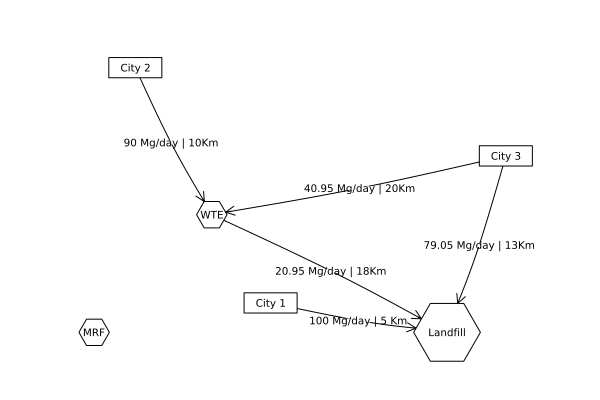

In [12]:
# Adjacency matrix for 6 nodes
A = [0 0 0 0 1 0;   # Edge from City 1 Landfill
     0 0 0 0 0 1;   # Edge from City 2 to WTE
     0 0 0 0 1 1;   # Edge from City 3 to Landfill + WTE
     0 0 0 0 0 0;   # MRF
     0 0 0 0 0 0;   # Landfill (updated)
     0 0 0 0 1 0];  # WTE to Landfill

# Node labels
names = ["City 1", "City 2", "City 3", "MRF", "Landfill", "WTE"]

# Edge labels (flow values)
edge_labels = Dict(
    (1, 5) => "100 Mg/day | 5 Km",  
    (2, 6) => "90 Mg/day | 10Km",   
    (3, 5) => "79.05 Mg/day | 13Km",
    (3, 6) => "40.95 Mg/day | 20Km",
    (6, 5) => "20.95 Mg/day | 18Km", 
      
)

# Shapes for nodes
shapes = [:rect, :rect, :rect, :hexagon, :hexagon, :hexagon]

# Node positions for 6 nodes
xpos = [1.5, -0.8, 5.5, -1.5, 4.5, 0.5]
ypos = [0, 4, 2.5, -0.5, -0.5, 1.5]

# Create and display the graph
p = graphplot(
    A,
    names=names,
    edgelabel=edge_labels,
    markersize=0.48,      # Adjust marker size for visibility
    markershapes=shapes, # Set node shapes
    markercolor=:white,  # Node background color
    x=xpos,              # Set x positions
    y=ypos               # Set y positions
)

display(p)


## References

List any external references consulted, including classmates.